In [1]:
%pylab inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


### A simplistic PyMC3 port of Bob Carpenter's [The Impact of Reparameterization on Point Estimates](http://mc-stan.org/documentation/case-studies/mle-params.html) in STAN

#### Model 1: Chance-of-Success Parameterization

In [14]:
y = np.asarray([0, 1, 0, 1, 1, 0, 0, 1, 0, 0])
N = len(y)
with pm.Model():
    # Set Transform to None so it won't use theta_log_
    theta = pm.Uniform('theta', lower=0, upper=1, transform=None)
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    map_est = pm.find_MAP()
map_est

Optimization terminated successfully.
         Current function value: 6.730117
         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 9


{'theta': array(0.39999999984023277)}

In [15]:
y = np.asarray([0, 1, 0, 1, 1, 0, 0, 1, 0, 0])
N = len(y)
with pm.Model():
    # Set Transform to None so it won't use theta_log_
    theta = pm.Uniform('theta', lower=0, upper=1)
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    map_est = pm.find_MAP()

from scipy import special
(1 - 0) * special.expit(map_est["theta_interval__"]) + 0

Optimization terminated successfully.
         Current function value: 8.150319
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


0.41666666866010721

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 7.8871:   0%|          | 874/200000 [00:00<00:22, 8738.42it/s]
Convergence archived at 1100
Interrupted at 1,100 [0%]: Average Loss = 7.8754
100%|██████████| 4000/4000.0 [00:02<00:00, 1474.70it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '81332' (I am process '81333')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '81332' (I am process '81334')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '81333' (I am process '81334')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-16.

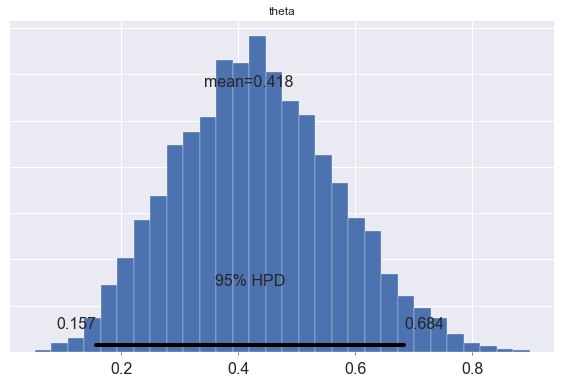

In [17]:
with pm.Model():
    # Set Transform to None so it won't use theta_log_
    theta = pm.Uniform('theta', lower=0, upper=1)
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    trace = pm.sample(3e3, tune=1000, njobs=4)
pm.plot_posterior(trace[1000:]);

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
  0%|          | 0/200000 [00:00<?, ?it/s]
Convergence archived at 200
Interrupted at 200 [0%]: Average Loss = 9.6868
100%|█████████▉| 3990/4000.0 [00:07<00:00, 550.12it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 3 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 4000/4000.0 [00:07<00:00, 528.89it/s]
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


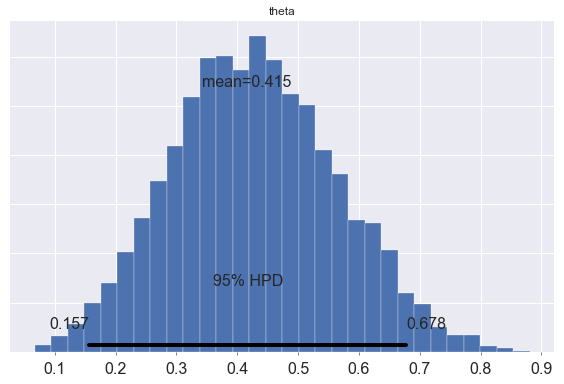

In [16]:
with pm.Model():
    # Set Transform to None so it won't use theta_log_
    theta = pm.Uniform('theta', lower=0, upper=1, transform=None)
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    trace = pm.sample(3e3, tune=1000, njobs=4, nuts_kwargs={'target_accept':.99})
pm.plot_posterior(trace[1000:]);

#### Model 2: Log Odds Parameterization without Jacobian

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 6.22: 100%|██████████| 200000/200000 [00:09<00:00, 20162.21it/s]  
Finished [100%]: Average Loss = 6.2199
100%|██████████| 3000/3000.0 [00:01<00:00, 2217.99it/s]


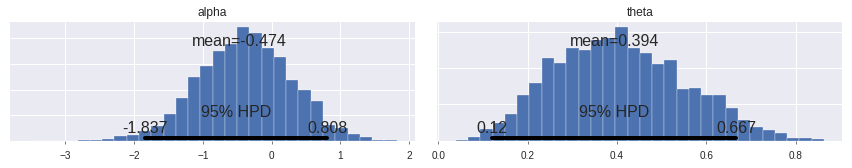

In [3]:
with pm.Model():
    alpha = pm.Flat('alpha')
    theta = pm.Deterministic('theta', pm.math.invlogit(alpha))
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    trace = pm.sample(3e3, tune=1000, njobs=4)
pm.plot_posterior(trace[1000:]);

#### Model 3: Log Odds with Jacobian Adjustment

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 7.7425: 100%|██████████| 200000/200000 [00:09<00:00, 20152.30it/s]
Finished [100%]: Average Loss = 7.7424
100%|██████████| 3000/3000.0 [00:01<00:00, 2157.08it/s]


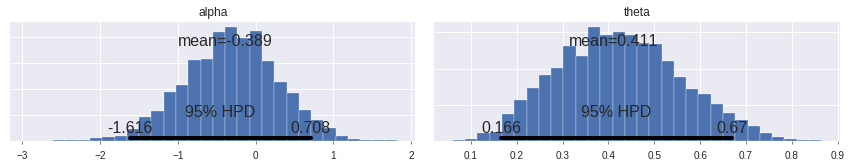

In [4]:
with pm.Model():
    alpha = pm.Flat('alpha')
    theta = pm.Deterministic('theta', pm.math.invlogit(alpha))
    
    def logp(value):
        return tt.sum(tt.sum(pm.Bernoulli.dist(p=theta).logp(value)) + \
                      tt.log(theta) + 
                      tt.log(1-theta))
    obs = pm.DensityDist('obs', logp, observed=y)
    
    trace = pm.sample(3e3, tune=1000, njobs=4)
pm.plot_posterior(trace[1000:]);

#### Model 3.1: Jacobian Adjustment using `pm.Potential`
`pm.Potential` is the `increment_log_prob` equivalent in PyMC3

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 7.7425: 100%|██████████| 200000/200000 [00:10<00:00, 19846.30it/s]
Finished [100%]: Average Loss = 7.7424
100%|██████████| 3000/3000.0 [00:01<00:00, 2195.05it/s]


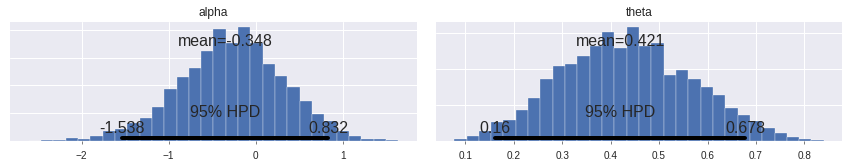

In [5]:
with pm.Model():
    alpha = pm.Flat('alpha')
    theta = pm.Deterministic('theta', pm.math.invlogit(alpha))
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    constrain = pm.Potential('constrain', tt.log(theta)+tt.log(1-theta))
    trace = pm.sample(3e3, tune=1000, njobs=4)
pm.plot_posterior(trace[1000:]);